In [3]:
import math
import datetime
import warnings
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima

import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from arch import arch_model

import itertools

warnings.filterwarnings('ignore')

# Task 1

### 1. Time series regression models use the same assumptions as linear regression models - ***partly true***

Многие предположения у регрессии временных рядов и классической регрессией общие: линейность, независимость и гомоскедастичность. Однако, для временных рядов часто требуют дополнительные условия: стационарность и автокорреляция. Хотя основные предположения о линейности и нормальности ошибок остаются, анализ временных рядов часто требует корректировок для учета уникальных характеристик временно-зависимых данных.

### 2. Autocorrelation is not an issue in time series regression models - ***true***


Если говорить об автокорреляции самого ряда, то это не проблема - на корреляции значения временного ряда с предыдущими значениями строится модель AR, к примеру (и все надстройки над ней). Проблемой является корреляция остатков (residuals), так как в построении этих моделей мы предполагаем независимость ошибок.

### 3. The Augmented Dickey-Fuller test is used to test the presence of seasonality in a time series - ***false***


Расширенный тест Дики-Фуллера (ADF) используется для проверки наличия единичного корня, чтобы проверить, является ли ряд стационарным или нестационарным. Он не предназначен для проверки сезонности.

### 4. Time series data must be stationary before applying most time series regression models - ***partly true***

В целом да, однако модели типа ARIMA(p, d, q) предпологают, что мы можем задать параметр дифференциирования ряда, так что формально данные для этой модели могут быть не стационарными - мы заранее проверяем, сколько раз необходимо взять разности для стационарности и используем это значение в качестве d.

### 5. The moving average model is a type of autoregressive model - ***false***

Модель скользящего среднего (MA) и авторегрессионная (AR) модель - это два разных подходы моделирования временных рядов. AR - регрессия с прошлыми значениями переменной, MA - регрессия с прошлыми ошибки прогнозирования. Стационарная модель AR может быть представлена в виде MA($∞$), так что можно было бы назвать AR разновидностью MA, но точно не наоборот.

### 6. The Box-Jenkins methodology is a popular approach for selecting the appropriate ARIMA model - ***true***

Подход Бокса-Дженкинса работы со стационарными рядами можно представить
в следующем виде:
1. Выбор порядка модели;
2. оценка модели выбранного порядка;
3. проверка “адекватности”;
4. прогнозирование.

### 7. In time series regression models, ergodicity implies that the time average of a process converges to its expected value - ***true***.

Процесс называется эргодическим, если любая его статистическая характеристика равна соответствующей характеристике, полученной усреднением по времени одной реализации. В контексте временных рядов означает, что временные средние и ансамблевые средние сходятся к одному и тому же значению с течением времени.

### 8. Volatility clustering refers to the phenomenon where periods of high volatility in time series data tend to be followed by periods of low volatility - ***false***

Кластеризация волатильности - явление, когда за высокой волатильностью с большей вероятностью последует высокая волатильность, а за низкой - низкая. Это означает, что если временной ряд испытывает высокую волатильность в какой-то момент времени, то он, скорее всего, снова испытает высокую волатильность вскоре после этого. Эта свойственно финансовым временным рядам.

# Task 2

Estimate an ARIMA(p, d, q)-GARCH(r, s) model following the Box- Jenkins methodology
1. Run a unit root test. (4 points)

    a. State the null hypothesis.

    b. Run the test.

    c. Interpret the result: is the unit root present?
2. Choose the degree of differencing d for ARIMA(p, d, q). (2 points)

    a. Explain how you chose it.
3. Find the other hyperparameters {p, q, r, s} of the model using AIC. (8 points)
    
    a. Explain the algorithm you used for this task.
4. Estimate the coefficients of the final model. (2 points)

    a. Print out the estimated coefficients.
5. Check model assumptions and show appropriate plots. (6 points)

    a. Residuals must be approximately uncorrelated.

    b. Residuals must be approximately normally distributed.
6. Plot the estimated conditional mean and conditional variance. (2 points)

### Данные:

In [4]:
df = pd.read_csv('/content/INPUT_TS.csv')
df['Price'] = df['Price'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df[['Price']]
df.sort_index(inplace=True)
df.head()

,Price
Date,
2018-02-01,135.35
2018-02-02,133.50
2018-02-05,138.40
2018-02-06,135.50
2018-02-07,136.45


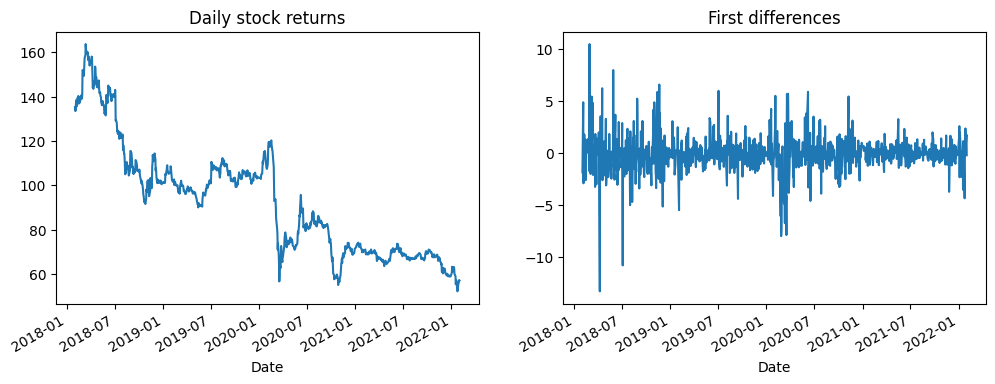

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df['Price'].plot(ax = axs[0])
axs[0].set_title('Daily stock returns')
df['Price'].diff().dropna().plot(ax = axs[1])
axs[1].set_title('First differences')
fig.show()

### Unit root test:

Для проверки на стационарность проведем тест Augmented Dickey-Fuller (ADF). Для этого теста нулевая гипотеза утверждает, что в выборке временного ряда присутствует единичный корень (что означает нестационарность).

In [ ]:
time_series = df['Price']
result = adfuller(time_series)
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -1.6062616106961916
p-value: 0.48044737193416837


In [ ]:
time_series = df['Price'].diff().dropna()
result = adfuller(time_series)
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -13.775153288922866
p-value: 9.52067668697494e-26


Для исходного временного ряда p-value теста ADF составил 0.480, что не позволяет отвергать нулевую гипотезу о нестационарности. Для ряда первых разностей  p-value составил 9.5e-26, поэтому уверенно отвергаем нулевую гипотезу и подтверждаем стационарность.

Из этого следует, что в дальнейшем параметр дифференциирования в модели $d = 1$.

Из условия я не совсем поняла, в соответствии с какой метрикой/информационным критерием необходимо подбирать параметры, так как написано было следующее:

* Find the other hyperparameters {p, q, r, s} of the model using AIC.

* Use maximum likelihood for estimating coefficients.

Поэтому сделаю это и с помощью AIC, и с помощью loglikelyhood. Помимо этого, я попробую подбирать параметры последовательно - сначала для ARIMA, далее для GARCH для остатков выбранной ARIMA; а также совокупно - рассчитывая суммарную метрику ARIMA и GARCH для каждого набора параметров и выбирая оптимальную модель.

### Последовательный подбор параметров для исходного временного ряда (AIC) - ARIMA(4, 1, 0)-GARCH(2, 4):

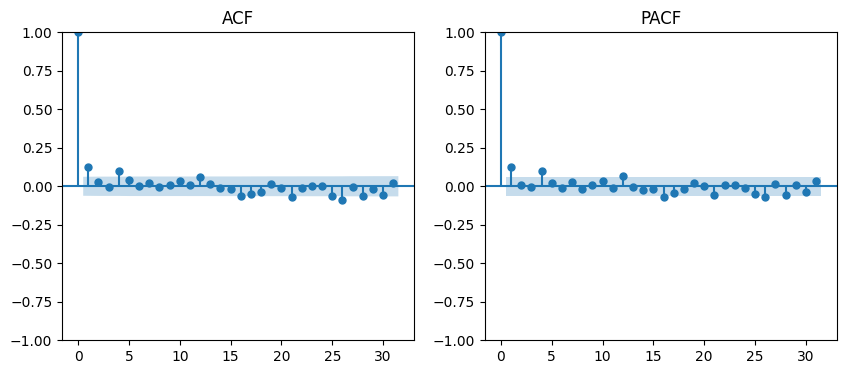

In [ ]:
time_series = df['Price'].diff().dropna()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(time_series, ax = axs[0])
axs[0].set_title('ACF')
plot_pacf(time_series, ax = axs[1])
axs[1].set_title('PACF')
fig.show()

Из графиков ACF и PACF можно сделать следующие выводы: и для AR, и для MA значимыми могут быть лаги до 4ого включительно, однако значимость 2 и 3 лагов может быть несущественна. Также возможна месячная сезонность, так как значимые корреляции видны между 25 и 30 лагами, однако в задании предложена модель без сезонности. Поэтому в дальнейшем при подборе параметров будем опираться на это.

In [ ]:
model_arima = auto_arima(df['Price'],
                         d = 1,
                         seasonal=False,
                         suppress_warnings=True,
                         stepwise=False,
                         trace = True)
model_arima.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3987.596, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3973.905, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3975.123, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3976.311, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3969.588, Time=0.47 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3969.854, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3973.312, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3975.229, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3974.758, Time=1.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3976.263, Time=1.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3970.194, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3975.230, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3975.903, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3976.725, Time=3.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3977.354, Time=4.86 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1010
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -1978.443
Date:                Mon, 16 Dec 2024   AIC                           3968.887
Time:                        18:35:43   BIC                           3998.387
Sample:                             0   HQIC                          3980.094
                               - 1010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0604      0.055     -1.098      0.272      -0.168       0.047
ar.L1          0.1259      0.023      5.451      0.000       0.081       0.171
ar.L2          0.0097      0.021      0.458      0.647      -0.032       0.051
ar.L3         -0.0204      0.025     -0.825      0.409      -0.069       0.028
ar.L4          0.1015      0.024      4.316      0.000       0.055       0.148
sigma2         2.9555      0.064     46.376      0.000       2.831       3.080
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2571.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Из summary видно, что коэффициенты при 2 и 3 лаге не значимы, что согласуется с ACF.

Проверим то же самое вручную:

In [8]:
ts = df['Price']

p_values = range(0, 5)
d = 1
q_values = range(0, 5)

best_aic = float("inf")
best_order = None

for p, q in itertools.product(p_values, q_values):
      model = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
      aic = model.aic
      if aic < best_aic:
          best_aic = aic
          best_order = (p, d, q)
      print(f'ARIMA({p},{d},{q}) - AIC: {round(aic, 3)}')

print(f'Best model: ARIMA{best_order} с AIC: {round(best_aic, 3)}')

ARIMA(0,1,0) - AIC: 3987.592
ARIMA(0,1,1) - AIC: 3973.529
ARIMA(0,1,2) - AIC: 3974.656
ARIMA(0,1,3) - AIC: 3975.915
ARIMA(0,1,4) - AIC: 3968.947
ARIMA(1,1,0) - AIC: 3972.869
ARIMA(1,1,1) - AIC: 3974.746
ARIMA(1,1,2) - AIC: 3973.886
ARIMA(1,1,3) - AIC: 3975.762
ARIMA(1,1,4) - AIC: 3969.422
ARIMA(2,1,0) - AIC: 3974.754
ARIMA(2,1,1) - AIC: 3975.411
ARIMA(2,1,2) - AIC: 3975.849
ARIMA(2,1,3) - AIC: 3976.498
ARIMA(2,1,4) - AIC: 3971.277
ARIMA(3,1,0) - AIC: 3976.728
ARIMA(3,1,1) - AIC: 3976.87
ARIMA(3,1,2) - AIC: 3973.614
ARIMA(3,1,3) - AIC: 3970.359
ARIMA(3,1,4) - AIC: 3972.202
ARIMA(4,1,0) - AIC: 3968.122
ARIMA(4,1,1) - AIC: 3969.792
ARIMA(4,1,2) - AIC: 3971.769
ARIMA(4,1,3) - AIC: 3972.245
ARIMA(4,1,4) - AIC: 3973.009
Best model: ARIMA(4, 1, 0) с AIC: 3968.122


In [22]:
best_aic = float('inf')
best_order = (0, 0)
model = sm.tsa.ARIMA(ts, order=(4, 1, 0)).fit()
residuals = model.resid

for r in range(1, 5):
    for s in range(5):
        model_garch = arch_model(residuals, vol='Garch', p=r, q=s)
        results = model_garch.fit(disp='off')
        print(f'GARCH({r}, {s}), AIC = {results.aic}')

        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (r, s)

print(f"Best GARCH order: {best_order}, AIC: {best_aic}")

GARCH(1, 0), AIC = 3873.4416806185745
GARCH(1, 1), AIC = 3748.914307345698
GARCH(1, 2), AIC = 3747.5066036453522
GARCH(1, 3), AIC = 3746.8570050588214
GARCH(1, 4), AIC = 3746.9344848961264
GARCH(2, 0), AIC = 3791.9404531696055
GARCH(2, 1), AIC = 3750.9143071638737
GARCH(2, 2), AIC = 3745.2993449639853
GARCH(2, 3), AIC = 3748.857004741809
GARCH(2, 4), AIC = 3742.6962238300966
GARCH(3, 0), AIC = 3790.2560747614693
GARCH(3, 1), AIC = 3752.9143078071434
GARCH(3, 2), AIC = 3747.2993449271653
GARCH(3, 3), AIC = 3750.8570054133293
GARCH(3, 4), AIC = 3744.683867764041
GARCH(4, 0), AIC = 3786.318291243062
GARCH(4, 1), AIC = 3781.825987275729
GARCH(4, 2), AIC = 3749.2994502588717
GARCH(4, 3), AIC = 3752.8570052615414
GARCH(4, 4), AIC = 3745.386715755306
Best GARCH order: (2, 4), AIC: 3742.6962238300966


Найденная этим способом оптимальная модель - ARIMA(4, 1, 0)-GARCH(2, 4).

In [5]:
time_series = df['Price']
model_arima = ARIMA(time_series, order=(4, 1, 0)).fit()
print(model_arima.summary())

residuals = model_arima.resid
model_garch = arch_model(residuals, vol='Garch', p=2, q=4).fit(disp='off')
print(model_garch.summary())

arima_forecast = model_arima.predict()
garch_volatility_forecast = model_garch.conditional_volatility

df_predictions = pd.DataFrame(
    {'historical': time_series, 'pred': arima_forecast }, index=time_series.index
)

fig = go.Figure()
fig = px.line(df_predictions)
fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast - 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill=None,
    name='GARCH confidence interval lower bound',
    line=dict(color='pink', width=0)
))

fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast + 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill='tonexty',
    name='GARCH confidence interval upper bound',
    line=dict(color='pink', width=0)
))
fig.show()

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1010
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1979.061
Date:                Tue, 17 Dec 2024   AIC                           3968.122
Time:                        17:45:31   BIC                           3992.706
Sample:                             0   HQIC                          3977.462
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1272      0.023      5.510      0.000       0.082       0.172
ar.L2          0.0110      0.021      0.520      0.603      -0.030       0.052
ar.L3         -0.0192      0.025     -0.780      0.4

Аналогично - коэффиценты при 2 и 3 лагах не значимы.

In [11]:
rolling_vol_resid = abs(residuals.rolling(window=22, min_periods=22).std())
df_predictions_vol = pd.DataFrame(
    {'historical volatility od residuals': rolling_vol_resid, 'predicted volatility with GARCH': garch_volatility_forecast}, index=residuals.index
)
fig = px.line(df_predictions_vol.dropna().iloc[50:])
fig.show()

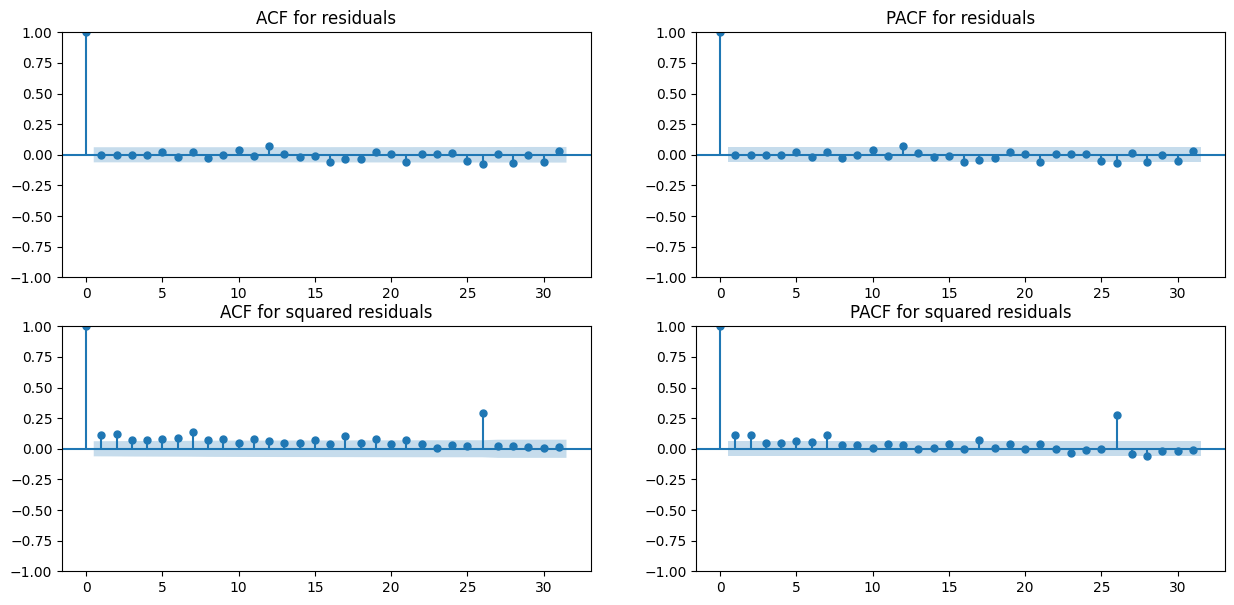

In [6]:
time_series = residuals
time_series = time_series.iloc[1:] #так как самый первый остаток очень большой, особенно squared

fig, axs = plt.subplots(2, 2, figsize=(15, 7))

plot_acf(time_series, ax = axs[0, 0])
axs[0, 0].set_title('ACF for residuals')
plot_pacf(time_series, ax = axs[0, 1])
axs[0, 1].set_title('PACF for residuals')

plot_acf(time_series**2, ax = axs[1, 0])
axs[1, 0].set_title('ACF for squared residuals')
plot_pacf(time_series**2, ax = axs[1, 1])
axs[1, 1].set_title('PACF for squared residuals')

fig.show()

Text(0.5, 1.0, 'Q-Q plot of Residuals')

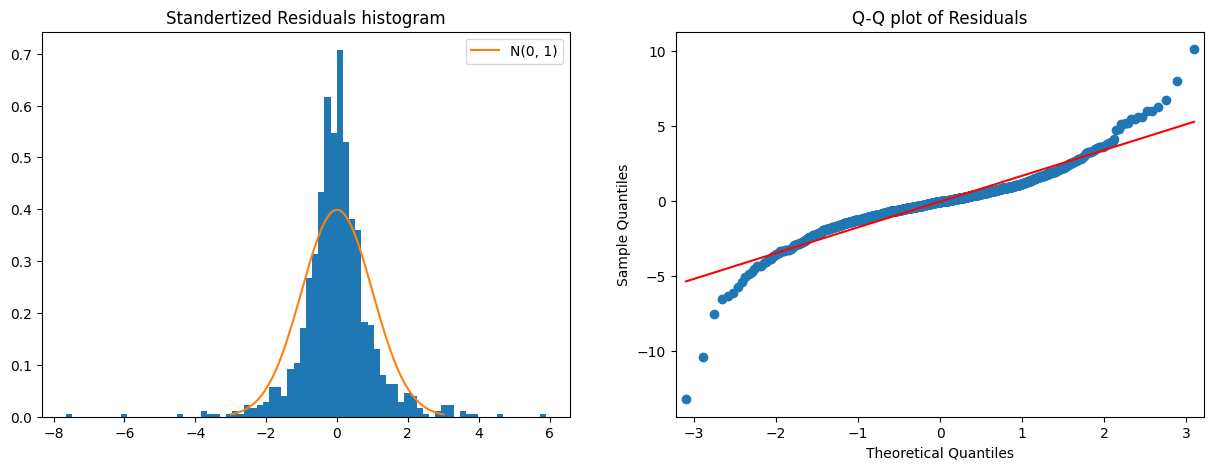

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

st_residuals = (time_series - time_series.mean())/time_series.std()
axs[0].hist(st_residuals, bins = 'auto', density=True)
axs[0].set_title("Standertized Residuals histogram")
x = np.linspace(-3, 3, 1000)
axs[0].plot(x, stats.norm.pdf(x, 0, 1), label = 'N(0, 1)')
axs[0].legend()

sm.qqplot(time_series, line='s', ax = axs[1])
axs[1].set_title('Q-Q plot of Residuals')


По qq-plot и гистограмме нормированных остатков можно сделать вывод о том, что остатки нельзя назвать нормально распределенными, однако их распределение напоминает по форме нормальное - оно также симметрично, унимодально, однако одновременно более острое и имеет более тяжелые хвосты (поэтому это не похоже на t-распределение).

$$
\omega = \sigma ^2 (1 - ∑\alpha_i - ∑\beta_i)
$$

In [10]:
#                  coef    std err          t      P>|t|     95.0% Conf. Int.
# ---------------------------------------------------------------------------
# omega          0.1420  8.969e-02      1.583      0.113 [-3.383e-02,  0.318]
# alpha[1]       0.2352  7.884e-02      2.984  2.849e-03  [8.070e-02,  0.390]
# alpha[2]       0.0690      0.211      0.327      0.744    [ -0.345,  0.483]
# beta[1]        0.0000      1.100      0.000      1.000    [ -2.156,  2.156]
# beta[2]        0.3635      0.164      2.223  2.622e-02  [4.301e-02,  0.684]
# beta[3]        0.0000      0.820      0.000      1.000    [ -1.607,  1.607]
# beta[4]        0.2885      0.125      2.304  2.124e-02  [4.303e-02,  0.534]

omega = 0.1420
alpha1 = 0.2352
alpha2 = 0.0690 #статистически не значим
beta1 = 0 #статистически не значим
beta2 = 0.3635
beta3 = 0 #статистически не значим
beta4 = 0.2885
sigma = np.sqrt(omega / (1 - alpha1 - beta2 - beta4))
sigma

1.1219916435637787

In [8]:
residuals.std()

4.594596299656359

### Последовательный подбор параметров для исходного временного ряда (loglikelihood) - ARIMA(4, 1, 4)-GARCH(4, 4):

In [18]:
ts = df['Price']

p_values = range(0, 5)
d = 1
q_values = range(0, 5)

best_llf = float('-inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
      model = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
      llf = model.llf
      if llf > best_llf:
          best_llf = llf
          best_order = (p, d, q)
      print(f'ARIMA({p},{d},{q}) - log-likelihood: {round(llf, 3)}')

print(f'Best model: ARIMA{best_order} с log-likelihood: {round(best_llf, 3)}')

ARIMA(0,1,0) - log-likelihood: -1992.796
ARIMA(0,1,1) - log-likelihood: -1984.765
ARIMA(0,1,2) - log-likelihood: -1984.328
ARIMA(0,1,3) - log-likelihood: -1983.958
ARIMA(0,1,4) - log-likelihood: -1979.473
ARIMA(1,1,0) - log-likelihood: -1984.435
ARIMA(1,1,1) - log-likelihood: -1984.373
ARIMA(1,1,2) - log-likelihood: -1982.943
ARIMA(1,1,3) - log-likelihood: -1982.881
ARIMA(1,1,4) - log-likelihood: -1978.711
ARIMA(2,1,0) - log-likelihood: -1984.377
ARIMA(2,1,1) - log-likelihood: -1983.706
ARIMA(2,1,2) - log-likelihood: -1982.924
ARIMA(2,1,3) - log-likelihood: -1982.249
ARIMA(2,1,4) - log-likelihood: -1978.638
ARIMA(3,1,0) - log-likelihood: -1984.364
ARIMA(3,1,1) - log-likelihood: -1983.435
ARIMA(3,1,2) - log-likelihood: -1980.807
ARIMA(3,1,3) - log-likelihood: -1978.18
ARIMA(3,1,4) - log-likelihood: -1978.101
ARIMA(4,1,0) - log-likelihood: -1979.061
ARIMA(4,1,1) - log-likelihood: -1978.896
ARIMA(4,1,2) - log-likelihood: -1978.884
ARIMA(4,1,3) - log-likelihood: -1978.122
ARIMA(4,1,4) - lo

In [16]:
best_llf = float('-inf')
best_order = (0, 0)
model = sm.tsa.ARIMA(ts, order=(4, 1, 4)).fit()
residuals = model.resid

for r in range(1, 5):
    for s in range(5):
        model_garch = arch_model(residuals, vol='Garch', p=r, q=s)
        results = model_garch.fit(disp='off')
        print(f'GARCH({r}, {s}), log-likelihood = {results.loglikelihood}')

        if results.loglikelihood > best_llf:
            best_llf = results.loglikelihood
            best_order = (r, s)

print(f"Best GARCH order: {best_order}, log-likelihood: {best_llf}")

GARCH(1, 0), log-likelihood = -1925.960759816676
GARCH(1, 1), log-likelihood = -1875.1794628866899
GARCH(1, 2), log-likelihood = -1867.1933805535145
GARCH(1, 3), log-likelihood = -1865.8368937974053
GARCH(1, 4), log-likelihood = -1864.360261103897
GARCH(2, 0), log-likelihood = -1889.9742216281943
GARCH(2, 1), log-likelihood = -1875.1794628474256
GARCH(2, 2), log-likelihood = -1875.0938804702018
GARCH(2, 3), log-likelihood = -1865.8368941206645
GARCH(2, 4), log-likelihood = -1860.6991937260382
GARCH(3, 0), log-likelihood = -1885.8179034160544
GARCH(3, 1), log-likelihood = -1875.1794632181623
GARCH(3, 2), log-likelihood = -1875.093880385208
GARCH(3, 3), log-likelihood = -1865.8368938188319
GARCH(3, 4), log-likelihood = -1860.699183644743
GARCH(4, 0), log-likelihood = -1884.0697068893655
GARCH(4, 1), log-likelihood = -1878.4708675619875
GARCH(4, 2), log-likelihood = -1875.093880517304
GARCH(4, 3), log-likelihood = -1865.836893890817
GARCH(4, 4), log-likelihood = -1860.1445779981032
Best G

In [13]:
model_arima = ARIMA(df['Price'], order=(4, 1, 4)).fit()
print(model_arima.summary())

residuals = model_arima.resid
model_garch = arch_model(residuals, vol='Garch', p=4, q=4).fit(disp='off')
print(model_garch.summary())

arima_forecast = model_arima.predict()
garch_volatility_forecast = model_garch.conditional_volatility

df_predictions = pd.DataFrame(
    {'historical': df['Price'], 'pred': arima_forecast }, index=time_series.index
)

fig = go.Figure()
fig = px.line(df_predictions)
fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast - 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill=None,
    name='GARCH confidence interval lower bound',
    line=dict(color='pink', width=0)
))

fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast + 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill='tonexty',
    name='GARCH confidence interval upper bound',
    line=dict(color='pink', width=0)
))
fig.show()

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1010
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1977.504
Date:                Tue, 17 Dec 2024   AIC                           3973.009
Time:                        17:51:38   BIC                           4017.259
Sample:                             0   HQIC                          3989.819
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7076      0.167      4.236      0.000       0.380       1.035
ar.L2          0.4470      0.138      3.229      0.001       0.176       0.718
ar.L3          0.3167      0.154      2.057      0.0

In [24]:
rolling_vol_resid = abs(residuals.rolling(window=22, min_periods=22).std())
df_predictions_vol = pd.DataFrame(
    {'historical volatility od residuals': rolling_vol_resid, 'predicted volatility with GARCH': garch_volatility_forecast}, index=residuals.index
)
fig = px.line(df_predictions_vol.dropna().iloc[50:])
fig.show()

Найденная этим способом оптимальная модель - ARIMA(4, 1, 4)-GARCH(4, 4).

ARIMA(4, 1, 4) хороша тем, что все коэффициенты получились статистически значимые.

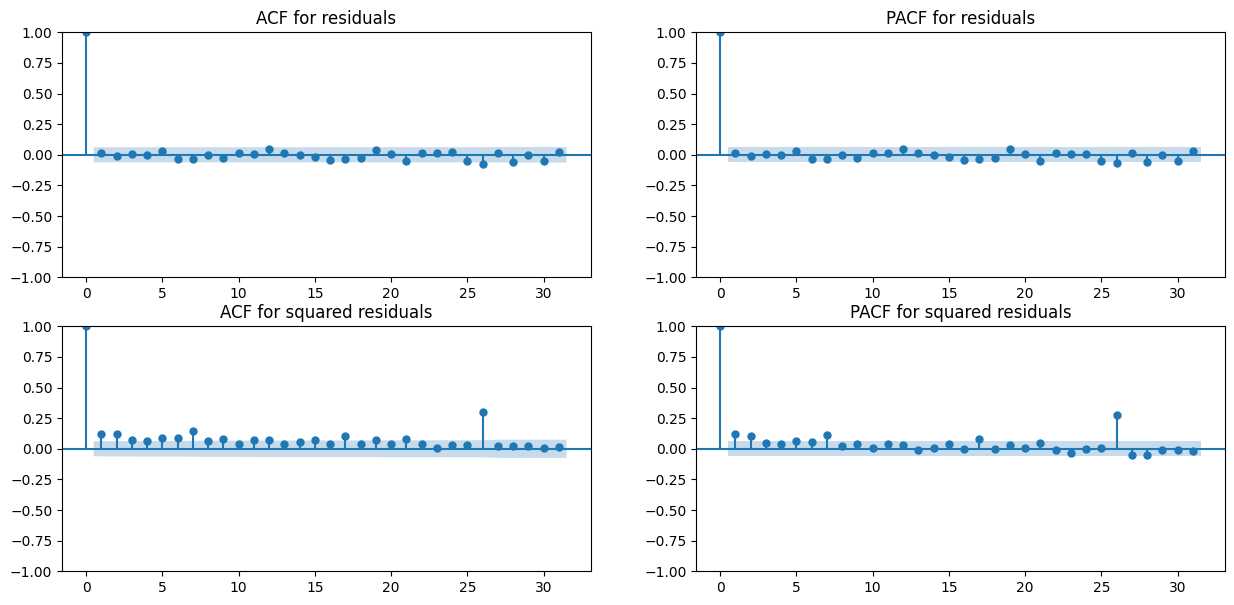

In [20]:
time_series = residuals
time_series = time_series.iloc[1:] #так как самый первый остаток очень большой, особенно squared

fig, axs = plt.subplots(2, 2, figsize=(15, 7))

plot_acf(time_series, ax = axs[0, 0])
axs[0, 0].set_title('ACF for residuals')
plot_pacf(time_series, ax = axs[0, 1])
axs[0, 1].set_title('PACF for residuals')

plot_acf(time_series**2, ax = axs[1, 0])
axs[1, 0].set_title('ACF for squared residuals')
plot_pacf(time_series**2, ax = axs[1, 1])
axs[1, 1].set_title('PACF for squared residuals')

fig.show()

Text(0.5, 1.0, 'Q-Q plot of Residuals')

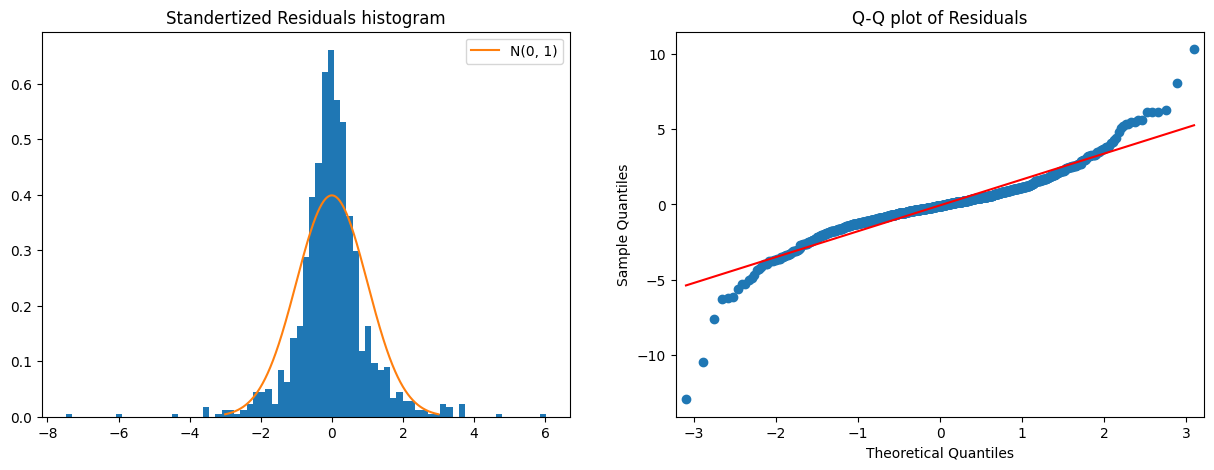

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

st_residuals = (time_series - time_series.mean())/time_series.std()
axs[0].hist(st_residuals, bins = 'auto', density=True)
axs[0].set_title("Standertized Residuals histogram")
x = np.linspace(-3, 3, 1000)
axs[0].plot(x, stats.norm.pdf(x, 0, 1), label = 'N(0, 1)')
axs[0].legend()

sm.qqplot(time_series, line='s', ax = axs[1])
axs[1].set_title('Q-Q plot of Residuals')


По qq-plot и гистограмме нормированных остатков можно сделать вывод о том, что остатки нельзя назвать нормально распределенными, однако их распределение напоминает по форме нормальное - оно также симметрично, унимодально, однако одновременно более острое и имеет более тяжелые хвосты (поэтому это не похоже на t-распределение).

In [14]:
#                  coef    std err          t      P>|t|       95.0% Conf. Int.
# -----------------------------------------------------------------------------
# omega          0.1947  8.507e-02      2.288  2.213e-02    [2.792e-02,  0.361]
# alpha[1]       0.2488  7.798e-02      3.191  1.420e-03    [9.596e-02,  0.402]
# alpha[2]       0.0694  5.683e-02      1.222      0.222   [-4.195e-02,  0.181]
# alpha[3]       0.0937  4.660e-02      2.012  4.427e-02    [2.402e-03,  0.185]
# alpha[4]   5.9686e-10  5.430e-02  1.099e-08      1.000      [ -0.106,  0.106]
# beta[1]        0.0000  3.553e-02      0.000      1.000 [-6.964e-02,6.964e-02]
# beta[2]        0.0000  2.744e-02      0.000      1.000 [-5.377e-02,5.377e-02]
# beta[3]        0.0000  2.900e-02      0.000      1.000 [-5.684e-02,5.684e-02]
# beta[4]        0.5376  6.565e-02      8.189  2.632e-16      [  0.409,  0.666]

omega = 0.1947
alpha1 = 0.2488
alpha2 = 0.0694 #статистически не значим
alpha3 = 0.0937
alpha4 = 0 #статистически не значим
beta1 = 0 #статистически не значим
beta2 = 0 #статистически не значим
beta3 = 0 #статистически не значим
beta4 = 0.5376
sigma = np.sqrt(omega / (1 - alpha1 - alpha3- beta4))
sigma

1.274304991361634

In [12]:
residuals.std()

4.593610186356087

### Совокупный подбор параметров (AIC) - ARIMA(3, 1, 3)-GARCH(2, 4):

In [25]:
p = range(0, 5)
d = 1
q = range(0, 5)
r = range(1, 5)
s = range(0, 5)

results = []
best_aic = np.inf
best_params = None

for param in itertools.product(p, q):
    for garch_param in itertools.product(r, s):
            model_arima = ARIMA(df['Price'], order=(param[0], d, param[1])).fit()
            residuals = model_arima.resid
            model_garch = arch_model(residuals, vol='Garch', p=garch_param[0], q=garch_param[1]).fit(disp='off')
            if (model_arima.aic + model_garch.aic) < best_aic:
              best_aic = (model_arima.aic + model_garch.aic)
              best_params = ((param[0], d, param[1]), (garch_param[0], garch_param[1]))
            print(f'ARIMA({param[0]}, 1, {param[1]})-GARCH({garch_param[0]}, {garch_param[1]}), AIC = {model_arima.aic + model_garch.aic}')

print("Best ARIMA parameters (p,d,q):", best_params[0])
print("Best GARCH parameters (r,s):", best_params[1])
print("Lowest AIC:", best_aic)

ARIMA(0, 1, 0)-GARCH(1, 0), AIC = 7884.872680855704
ARIMA(0, 1, 0)-GARCH(1, 1), AIC = 7752.958835940677
ARIMA(0, 1, 0)-GARCH(1, 2), AIC = 7752.163429535198
ARIMA(0, 1, 0)-GARCH(1, 3), AIC = 7750.776100543036
ARIMA(0, 1, 0)-GARCH(1, 4), AIC = 7751.286190138275
ARIMA(0, 1, 0)-GARCH(2, 0), AIC = 7795.511087848654
ARIMA(0, 1, 0)-GARCH(2, 1), AIC = 7754.958836225247
ARIMA(0, 1, 0)-GARCH(2, 2), AIC = 7779.578459747183
ARIMA(0, 1, 0)-GARCH(2, 3), AIC = 7752.77609995534
ARIMA(0, 1, 0)-GARCH(2, 4), AIC = 7748.333994955303
ARIMA(0, 1, 0)-GARCH(3, 0), AIC = 7791.615800634569
ARIMA(0, 1, 0)-GARCH(3, 1), AIC = 7756.958836027334
ARIMA(0, 1, 0)-GARCH(3, 2), AIC = 7753.542334502366
ARIMA(0, 1, 0)-GARCH(3, 3), AIC = 7754.776100295704
ARIMA(0, 1, 0)-GARCH(3, 4), AIC = 7750.333993014476
ARIMA(0, 1, 0)-GARCH(4, 0), AIC = 7788.225858276495
ARIMA(0, 1, 0)-GARCH(4, 1), AIC = 7788.7709249461295
ARIMA(0, 1, 0)-GARCH(4, 2), AIC = 7783.578460049832
ARIMA(0, 1, 0)-GARCH(4, 3), AIC = 7756.77610079028
ARIMA(0, 1, 0

Найденная этим способом оптимальная модель - ARIMA(3, 1, 3)-GARCH(2, 4) с AIC  7706.887.

Для ранее полученных моделей:

ARIMA(4, 1, 0)-GARCH(2, 4), AIC = 7710.819

ARIMA(4, 1, 4)-GARCH(4, 4), AIC = 7713.298

In [15]:
model_arima = ARIMA(df['Price'], order=(3, 1, 3)).fit()
print(model_arima.summary())

residuals = model_arima.resid
model_garch = arch_model(residuals, vol='Garch', p=2, q=4).fit(disp='off')
print(model_garch.summary())

arima_forecast = model_arima.predict()
garch_volatility_forecast = model_garch.conditional_volatility

df_predictions = pd.DataFrame(
    {'historical': df['Price'], 'pred': arima_forecast }, index=time_series.index
)

fig = go.Figure()
fig = px.line(df_predictions)
fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast - 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill=None,
    name='GARCH confidence interval lower bound',
    line=dict(color='pink', width=0)
))

fig.add_trace(go.Scatter(
    x=time_series.index,
    y=arima_forecast + 1.96 * np.sqrt(garch_volatility_forecast),
    mode='lines',
    fill='tonexty',
    name='GARCH confidence interval upper bound',
    line=dict(color='pink', width=0)
))
fig.show()

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1010
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1978.180
Date:                Tue, 17 Dec 2024   AIC                           3970.359
Time:                        17:57:44   BIC                           4004.776
Sample:                             0   HQIC                          3983.435
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1704      0.151     -1.127      0.260      -0.467       0.126
ar.L2          0.1621      0.132      1.231      0.218      -0.096       0.420
ar.L3          0.5546      0.105      5.290      0.0

In [29]:
rolling_vol_resid = abs(residuals.rolling(window=22, min_periods=22).std())
df_predictions_vol = pd.DataFrame(
    {'historical volatility od residuals': rolling_vol_resid, 'predicted volatility with GARCH': garch_volatility_forecast}, index=residuals.index
)
fig = px.line(df_predictions_vol.dropna().iloc[50:])
fig.show()

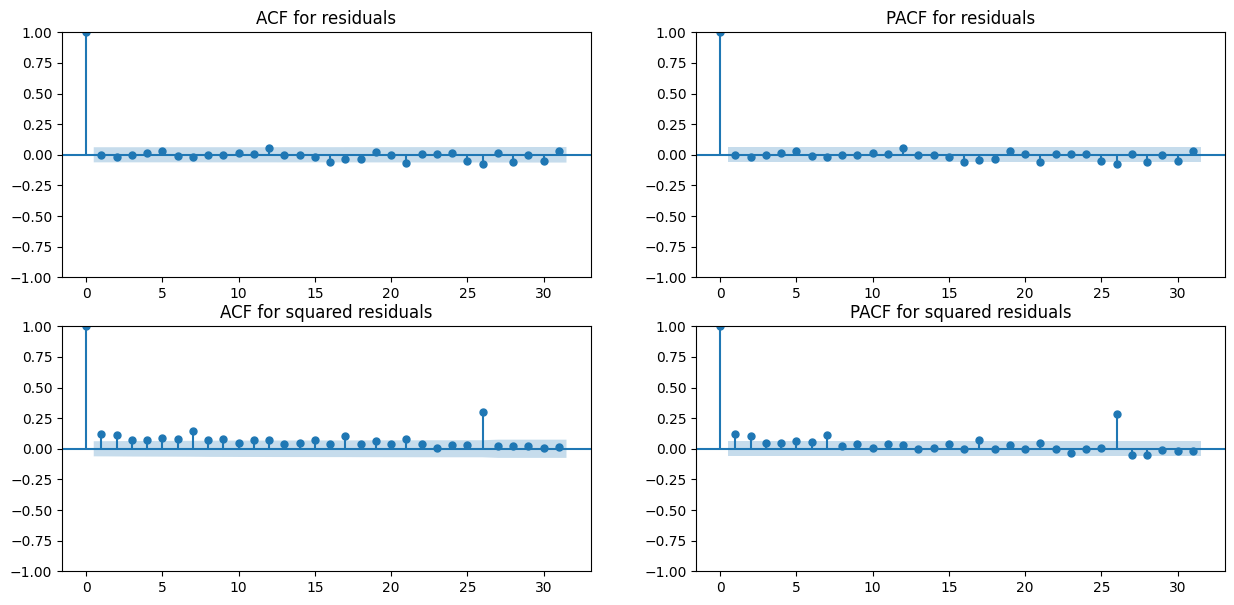

In [30]:
time_series = residuals
time_series = time_series.iloc[1:] #так как самый первый остаток очень большой, особенно squared

fig, axs = plt.subplots(2, 2, figsize=(15, 7))

plot_acf(time_series, ax = axs[0, 0])
axs[0, 0].set_title('ACF for residuals')
plot_pacf(time_series, ax = axs[0, 1])
axs[0, 1].set_title('PACF for residuals')

plot_acf(time_series**2, ax = axs[1, 0])
axs[1, 0].set_title('ACF for squared residuals')
plot_pacf(time_series**2, ax = axs[1, 1])
axs[1, 1].set_title('PACF for squared residuals')

fig.show()

Text(0.5, 1.0, 'Q-Q plot of Residuals')

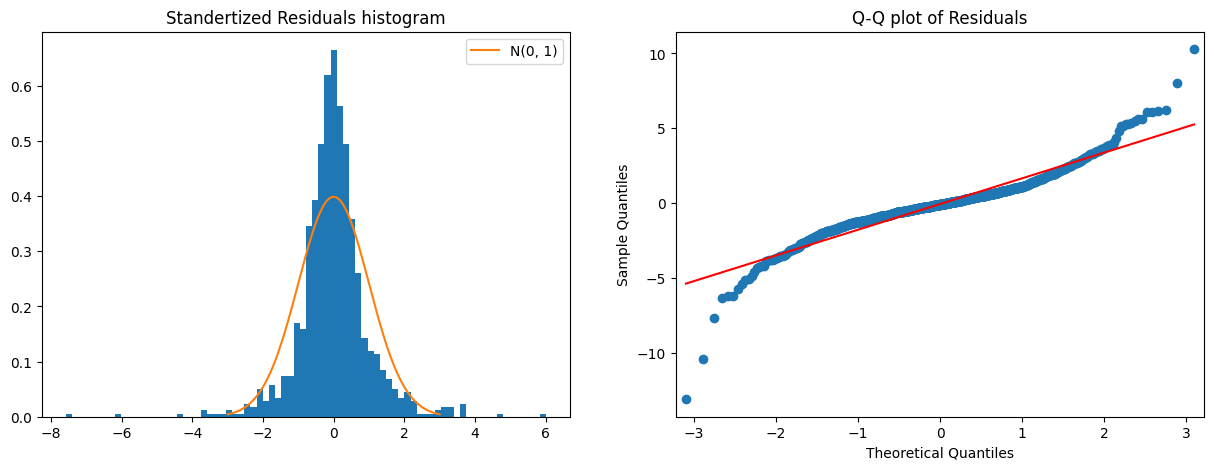

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

st_residuals = (time_series - time_series.mean())/time_series.std()
axs[0].hist(st_residuals, bins = 'auto', density=True)
axs[0].set_title("Standertized Residuals histogram")
x = np.linspace(-3, 3, 1000)
axs[0].plot(x, stats.norm.pdf(x, 0, 1), label = 'N(0, 1)')
axs[0].legend()

sm.qqplot(time_series, line='s', ax = axs[1])
axs[1].set_title('Q-Q plot of Residuals')


По qq-plot и гистограмме нормированных остатков можно сделать вывод о том, что остатки нельзя назвать нормально распределенными, однако их распределение напоминает по форме нормальное - оно также симметрично, унимодально, однако одновременно более острое и имеет более тяжелые хвосты (поэтому это не похоже на t-распределение).

In [18]:
#                  coef    std err          t      P>|t|     95.0% Conf. Int.
# ---------------------------------------------------------------------------
# omega          0.1435  9.602e-02      1.495      0.135 [-4.467e-02,  0.332]
# alpha[1]       0.2487  9.754e-02      2.550  1.079e-02  [5.751e-02,  0.440]
# alpha[2]       0.0631      0.266      0.237      0.813    [ -0.458,  0.585]
# beta[1]    9.7235e-08      1.273  7.641e-08      1.000    [ -2.494,  2.494]
# beta[2]        0.3476      0.152      2.286  2.227e-02  [4.954e-02,  0.646]
# beta[3]    8.1594e-08      0.944  8.644e-08      1.000    [ -1.850,  1.850]
# beta[4]        0.2977      0.123      2.413  1.584e-02  [5.586e-02,  0.540]

omega = 0.135 #статистически не значим
alpha1 = 0.2487
alpha2 = 0.0631 #статистически не значим
beta1 = 0 #статистически не значим
beta2 = 0.3476
beta3 = 0 #статистически не значим
beta4 = 0.2977
sigma = np.sqrt(omega / (1 - alpha1 - alpha2 - beta1 - beta3- beta2 - beta4))
sigma

1.7739371879672503

In [17]:
residuals.std()

4.593980074231844

### Совокупный подбор параметров (loglikelihood) - ARIMA(4, 1, 4)-GARCH(4, 4):

In [31]:
p = range(0, 5)
d = 1
q = range(0, 5)
r = range(1, 5)
s = range(0, 5)

results = []
best_llf = float("-inf")
best_params = None

for param in itertools.product(p, q):
    for garch_param in itertools.product(r, s):
            model_arima = ARIMA(df['Price'], order=(param[0], d, param[1])).fit()
            residuals = model_arima.resid
            model_garch = arch_model(residuals, vol='Garch', p=garch_param[0], q=garch_param[1]).fit(disp='off')
            if (model_arima.llf + model_garch.loglikelihood) > best_llf:
              best_llf = model_arima.llf + model_garch.loglikelihood
              best_params = ((param[0], d, param[1]), (garch_param[0], garch_param[1]), model_arima.llf + model_garch.loglikelihood)
            print(f'ARIMA({param[0]}, 1, {param[1]})-GARCH({garch_param[0]}, {garch_param[1]}), log-likelihood = {model_arima.llf + model_garch.loglikelihood}')

print("Best ARIMA parameters (p,d,q):", best_params[0])
print("Best GARCH parameters (r,s):", best_params[1])
print("Highest LLH:", best_llf)



ARIMA(0, 1, 0)-GARCH(1, 0), log-likelihood = -3938.436340427852
ARIMA(0, 1, 0)-GARCH(1, 1), log-likelihood = -3871.4794179703385
ARIMA(0, 1, 0)-GARCH(1, 2), log-likelihood = -3870.081714767599
ARIMA(0, 1, 0)-GARCH(1, 3), log-likelihood = -3868.388050271518
ARIMA(0, 1, 0)-GARCH(1, 4), log-likelihood = -3867.6430950691374
ARIMA(0, 1, 0)-GARCH(2, 0), log-likelihood = -3892.755543924327
ARIMA(0, 1, 0)-GARCH(2, 1), log-likelihood = -3871.4794181126235
ARIMA(0, 1, 0)-GARCH(2, 2), log-likelihood = -3882.7892298735915
ARIMA(0, 1, 0)-GARCH(2, 3), log-likelihood = -3868.38804997767
ARIMA(0, 1, 0)-GARCH(2, 4), log-likelihood = -3865.1669974776514
ARIMA(0, 1, 0)-GARCH(3, 0), log-likelihood = -3889.8079003172843
ARIMA(0, 1, 0)-GARCH(3, 1), log-likelihood = -3871.479418013667
ARIMA(0, 1, 0)-GARCH(3, 2), log-likelihood = -3868.771167251183
ARIMA(0, 1, 0)-GARCH(3, 3), log-likelihood = -3868.388050147852
ARIMA(0, 1, 0)-GARCH(3, 4), log-likelihood = -3865.166996507238
ARIMA(0, 1, 0)-GARCH(4, 0), log-lik

Найденная этим способом оптимальная модель - ARIMA(4, 1, 4)-GARCH(4, 4) с LLH -3837.649, ее уже зафитила и проанализировала выше.

Для полученных ранее моделей:



ARIMA(4, 1, 0)-GARCH(2, 4), log-likelihood = -3842.409

ARIMA(3, 1, 3)-GARCH(2, 4), log-likelihood = -3838.443

## Выводы

В итоге наилучшей моделью я бы назвала  ARIMA(4, 1, 4)-GARCH(4, 4), так как именно эти параметры подобрались в двух из четырех оптимизаций, а также из-за того, что для ARIMA(4, 1, 4) статистически значимы все коэффициенты. Однако, ни для одной из моделей GARCH не были значимы все коэффициенты, а также ни в одном из случаев рассчитанная из параметров $\sigma$ не соответствовала расчитанной по историческим данным.

Для всех моделей остатки ARIMA были нескоррелированы. Что касается их распределения - нельзя назвать нормально распределенными, однако их распределение напоминает по форме нормальное: также симметрично, унимодально, однако одновременно более острое и имеет более тяжелые хвосты.